# 1조 김도영
---
## 주제 : 가위바위보 이미지 분류

### 자료 출처
- https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors

## DNN(Deep Neural Network) : 심층신경망
---


## [1] 데이터 준비 및 로딩

In [1]:
# 모듈 로딩
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.utils import set_random_seed, plot_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import save_model

In [2]:
# 한글 깨짐 방지
import platform

if platform.system()=='Windows':
    plt.rc('font',family='Malgun Gothic')
else:
    plt.rc('font',family='AppleGothic')

In [3]:
ga = os.listdir('./data/가위')
ba = os.listdir('./data/바위')
bo = os.listdir('./data/보')

## [2] 데이터 전처리

In [4]:
# 가위
ga_list=[]
for file in ga:
    im = plt.imread('data/가위/'+file)
    im = cv2.resize(im, (100, 100))
    # Dense Layer 입력 형태로 변환 -> 2차원 데이터 처리 
    im = im.reshape(-1, 100*100*3)
    ga_list.append(im)

In [5]:
# 바위
ba_list=[]
for file in ba:
    im = plt.imread('data/바위/'+file)
    im = cv2.resize(im, (100, 100))
    im = im.reshape(-1, 100*100*3)
    ba_list.append(im)

In [6]:
# 보
bo_list=[]
for file in bo:
    im = plt.imread('data/보/'+file)
    im = cv2.resize(im, (100, 100))
    im = im.reshape(-1, 100*100*3)
    bo_list.append(im)

In [7]:
# 하나의 데이터로 병합 <- numpy array 형태
ga1=np.concatenate(ga_list)
ba1=np.concatenate(ba_list)
bo1=np.concatenate(bo_list)

data =np.concatenate((ga1, ba1, bo1))

In [8]:
# 타겟 숫자 부여
v1=np.zeros(len(ga_list))
v2=np.ones(len(ba_list))
v3=np.ones(len(bo_list))*2

target=np.concatenate((v1,v2,v3))

In [9]:
# Target => 문자 => 수치화
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [10]:
ohencoder=OneHotEncoder()
target=ohencoder.fit(target.reshape(-1,1)).transform(target.reshape(-1,1))

In [11]:
# 희소 행렬 -> numpy array 형변환
target = target.toarray()

In [12]:
print(f'data.shape : {data.shape},  target.shape : {target.shape}')

data.shape : (2188, 30000),  target.shape : (2188, 3)


### 학습 데이터 테스트 데이터 분리

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
x_train, x_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    stratify=target,
                                                    random_state=42)

In [15]:
# 검증용 데이터 준비
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  stratify=y_train,
                                                  random_state=42)

In [16]:
print(f'x_train.shape : {x_train.shape}\nx_test.shape : {x_test.shape}\nx_val.shape : {x_val.shape}')

x_train.shape : (1230, 30000)
x_test.shape : (547, 30000)
x_val.shape : (411, 30000)


In [17]:
y_test.shape

(547, 3)

## [3] 모델 구성 및 생성
---
- 입력 형태 : 1차원
- 출력 형태 : 확률값 3개 출력
- 학습 방식 : 분류 - 다중분류

In [18]:
# W,b 초기값 고정
set_random_seed(6)

In [19]:
def createDNNModel(n_node):
    # 모델 객체 생성
    model=Sequential()
    # 입력
    model.add(Dense(units=n_node, activation='relu', input_shape=(30000,)))
#     model.add(Dropout(0.5))
    model.add(Dense(units=n_node, activation='relu'))
    model.add(Dense(units=n_node, activation='relu'))
    model.add(Dense(units=n_node, activation='relu'))
    model.add(Dense(units=n_node, activation='relu'))
    model.add(Dense(units=n_node, activation='relu')) 
    # 출력
    model.add(Dense(units=3, activation='softmax'))
    # 모델 생성
    model.compile(loss='categorical_crossentropy',  # 오차 계산(손실) 함수 설정
                  optimizer='adam',                 # W,b 최적화 방식 설정
                  metrics='accuracy')               # 모델의 성능 측정(평가) 항목 설정
    return model

In [20]:
models = createDNNModel(100)
models.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               3000100   
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 dense_2 (Dense)             (None, 100)               10100     
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dense_5 (Dense)             (None, 100)               10100     
                                                                 
 dense_6 (Dense)             (None, 3)                 3

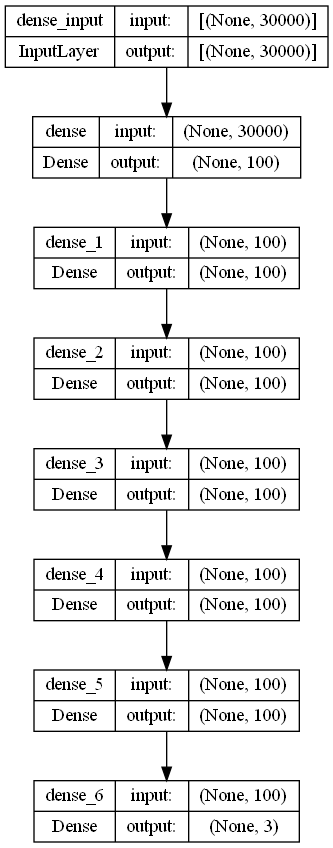

In [21]:
plot_model(models, show_shapes=True)

## [4] 모델 학습
---
- fit() 메서드
    * 학습 데이터, 라벨
    * epochs 학습횟수
    * batch_size 학습분량
    * validation_data (검증데이터, 검증라벨)
    * validation_split 학습데이터의 일부 비율 설정 (예:0.2)
    * callbacks
    * verbose 학습 진행도 화면 출력 여부 설정

In [22]:
# 검증 데이터에 대한 loss값 5번 연속 개선되지 않으면 학습 중지
stopCB = EarlyStopping(monitor='val_loss', patience=5)

In [23]:
# fit() 메서드 -> 반환값 : History 객체
his = models.fit(x_train, y_train, 
                 epochs=30,
                 batch_size=96,
                 validation_data=(x_val, y_val))
#                  callbacks=[stopCB])

Epoch 1/30
13/13 [==============================] - 1s 50ms/step - loss: 1.2318 - accuracy: 0.3626 - val_loss: 1.1140 - val_accuracy: 0.3260
Epoch 2/30
13/13 [==============================] - 0s 28ms/step - loss: 1.1105 - accuracy: 0.3976 - val_loss: 0.9996 - val_accuracy: 0.3698
Epoch 3/30
13/13 [==============================] - 0s 27ms/step - loss: 0.9645 - accuracy: 0.5171 - val_loss: 0.8210 - val_accuracy: 0.6326
Epoch 4/30
13/13 [==============================] - 0s 27ms/step - loss: 0.8294 - accuracy: 0.6602 - val_loss: 0.7596 - val_accuracy: 0.7032
Epoch 5/30
13/13 [==============================] - 0s 27ms/step - loss: 0.6835 - accuracy: 0.7293 - val_loss: 0.6036 - val_accuracy: 0.7932
Epoch 6/30
13/13 [==============================] - 0s 27ms/step - loss: 0.6359 - accuracy: 0.7618 - val_loss: 0.5287 - val_accuracy: 0.8175
Epoch 7/30
13/13 [==============================] - 0s 26ms/step - loss: 0.5358 - accuracy: 0.8114 - val_loss: 0.5775 - val_accuracy: 0.7689
Epoch 8/30
13

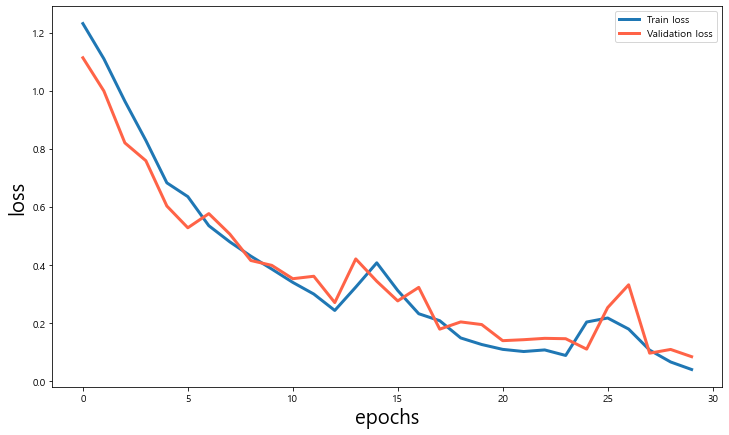

In [24]:
# 시각화
plt.figure(figsize=(12,7))
plt.plot(his.epoch, his.history['loss'], label='Train loss', linewidth=3)
plt.plot(his.epoch, his.history['val_loss'], label='Validation loss', color='tomato', linewidth=3)
plt.xlabel('epochs', fontsize=20)
plt.ylabel('loss', fontsize=20)
plt.legend()
plt.show()

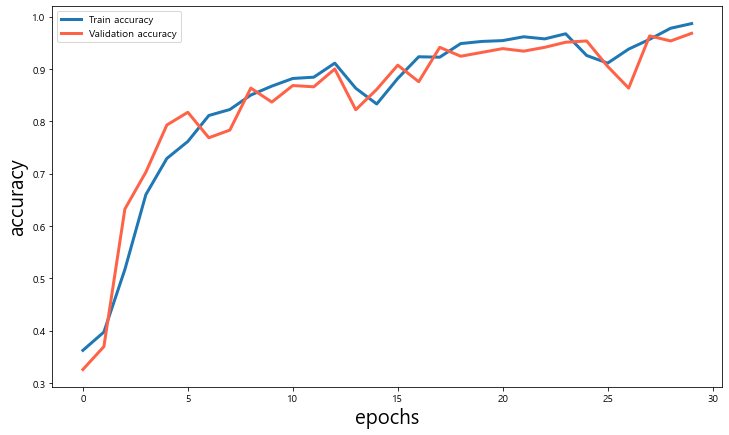

In [25]:
# 시각화
plt.figure(figsize=(12,7))
plt.plot(his.epoch, his.history['accuracy'], label='Train accuracy', linewidth=3)
plt.plot(his.epoch, his.history['val_accuracy'], label='Validation accuracy',color='tomato', linewidth=3)
plt.xlabel('epochs', fontsize=20)
plt.ylabel('accuracy', fontsize=20)
plt.legend()
plt.show()

## [5] 모델 평가
---
- evaluate() 메서드
- 반환값 : loss, compile()의 metrics에서 설정한 항목값

In [26]:
lossv, accv = models.evaluate(x_test, y_test)

18/18 [==============================] - 0s 7ms/step - loss: 0.1650 - accuracy: 0.9452


## [6] 모델 저장

In [27]:
from tensorflow.keras.models import save_model

In [28]:
M_FILE='rspModel.h5'
W_FILE='rspWeight.h5'

In [29]:
if accv >= 0.93:
    save_model(models, M_FILE)
    models.save_weights(W_FILE)

## [7] 예측
---
- 새로운 데이터

실제값 : [[0. 0. 1.]] ◀ 보
예측값 : [[0. 0. 1.]] ◀ 보


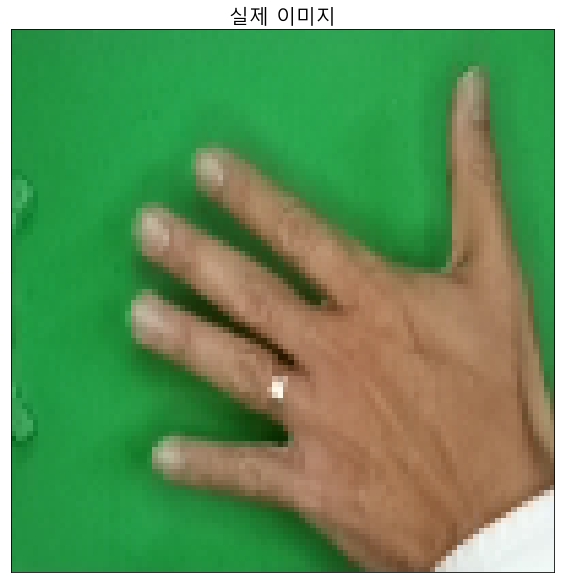

			▶ 예측 성공 !! ◀


In [30]:
import random
# random.seed(42)
label=['가위','바위','보']

ran = random.randint(0,len(x_test)-1)

pre_out = models.predict(x_test[ran].reshape(-1,30000), verbose='Flase')

# 실제값
print(f'실제값 : [{y_test[ran]}] ◀ {label[y_test[ran].argmax()]}')

# 예측값
print(f'예측값 : {np.round(pre_out)} ◀ {label[pre_out.argmax()]}')

# 실제 이미지
plt.figure(figsize=(10,10))
plt.title('실제 이미지', fontsize=20)
plt.xticks([], [])
plt.yticks([], [])
plt.imshow(x_test[ran].reshape(100,100,3))
plt.show()

if np.round(pre_out).argmax() == y_test[ran].argmax():
    print('\t\t\t▶ 예측 성공 !! ◀')
elif np.round(pre_out).argmax() != y_test[ran].argmax():
    print('\t\t\t▷ 예측 실패 !! ◁')

실제값 : [[0. 1. 0.]] ◀ 바위
예측값 : [[0. 1. 0.]] ◀ 바위


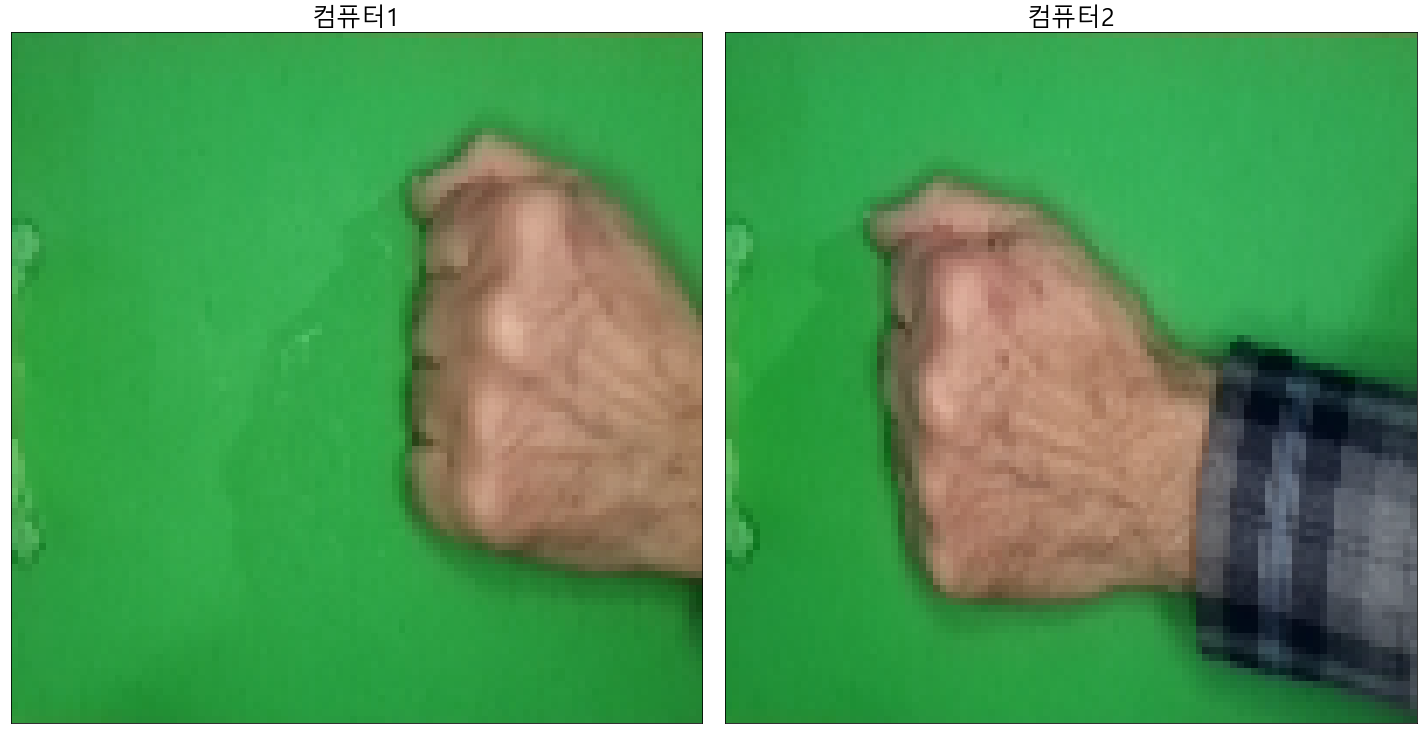

							▶ 무승부 ◀


In [31]:
import random
# random.seed(42)
label=['가위','바위','보']

ran = random.randint(0,len(x_test)-1)
ran_1 = random.randint(0,len(x_val)-1)

pre_out = models.predict(x_test[ran].reshape(-1,30000), verbose='Flase')

# 실제값
print(f'실제값 : [{y_test[ran]}] ◀ {label[y_test[ran].argmax()]}')

# 예측값
print(f'예측값 : {np.round(pre_out)} ◀ {label[pre_out.argmax()]}')

# 실제 이미지
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('컴퓨터1', fontsize=25)
plt.xticks([], [])
plt.yticks([], [])
plt.imshow(x_test[ran].reshape(100,100,3))

# 새로운 이미지
plt.subplot(122)
plt.title('컴퓨터2', fontsize=25)
plt.xticks([], [])
plt.yticks([], [])
plt.imshow(x_val[ran_1].reshape(100,100,3))

plt.tight_layout()
plt.show()

if (y_test[ran] == np.round(pre_out)).tolist() == [[True, True, True]]:
    if y_test[ran][0]==1:
        if (y_val[ran_1] == [1., 0., 0.]).tolist() == [True, True, True]:
            print('\t\t\t\t\t\t\t▶ 무승부 ◀')
        elif (y_val[ran_1] == [0., 1., 0.]).tolist() == [True, True, True]:
            print('\t\t\t\t\t\t\t▶ 컴퓨터2 승리 ◀')
        elif (y_val[ran_1] == [0., 0., 1.]).tolist() == [True, True, True]:
            print('\t\t\t\t\t\t\t▶ 컴퓨터1 승리 ◀')

    elif y_test[ran][1]==1:
        if (y_val[ran_1] == [1., 0., 0.]).tolist() == [True, True, True]:
            print('\t\t\t\t\t\t\t▶ 컴퓨터1 승리 ◀')
        elif (y_val[ran_1] == [0., 1., 0.]).tolist() == [True, True, True]:
            print('\t\t\t\t\t\t\t▶ 무승부 ◀')
        elif (y_val[ran_1] == [0., 0., 1.]).tolist() == [True, True, True]:
            print('\t\t\t\t\t\t\t▶ 컴퓨터2 승리 ◀')

    elif y_test[ran][2]==1:
        if (y_val[ran_1] == [1., 0., 0.]).tolist() == [True, True, True]:
            print('\t\t\t\t\t\t\t▶ 컴퓨터2 승리 ◀')
        elif (y_val[ran_1] == [0., 1., 0.]).tolist() == [True, True, True]:
            print('\t\t\t\t\t\t\t▶ 컴퓨터1 승리 ◀')
        elif (y_val[ran_1] == [0., 0., 1.]).tolist() == [True, True, True]:
            print('\t\t\t\t\t\t\t▶ 무승부 ◀')
elif (y_test[ran] == np.round(pre_out)).tolist() != [[True, True, True]]:
    print('\t\t\t\t\t\t\t▷ 예측 실패 !! ◁')